!pip install git+https://github.com/DeepTrackAI/deeplay

# MNIST digits generation with DDPM

We'll build a denoising diffusion probabilistic model (DDPM) to generate hand-written digits from the MNIST dataset.

## The MNIST dataset

The MNIST dataset consists of grayscale images of hand-written digits from 0 to 9. Each image is 28 pixels by 28 pixels. There're 60,000 training images and 10,000 test images.

We will download the dataset from the `torchvision` package of PyTorch. 

Before downloading the dataset, we will define the normalization that we will apply to the dataset through `torchvision.transforms` module. We will normalize the images to have pixel values between -1 and 1, which is a common practice for training ddpm models.

In [17]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5], inplace=True), # Normalize all images to [-1, 1]
])

We will apply the transforms created above to the training and test MNIST datasets.

The training and test datasets will be downloaded from the `torchvision.datasets` module, into the directory specified by the `root` argument. The `train` argument specifies whether to download the training or the test dataset by setting it to `True` or `False` respectively. Here, we will download the training dataset.

The `transform` argument specifies the transforms to be applied to the dataset. We will pass the transforms created above to this argument.

Set the `download` argument to `True` to download the dataset.

In [18]:
from torchvision.datasets import MNIST

trainset = MNIST(root="data", train=True, transform=transform, download=True)
valset = MNIST(root="data", train=False, transform=transform, download=True)

We can now visualize some images from the training dataset using the `matplotlib` package.

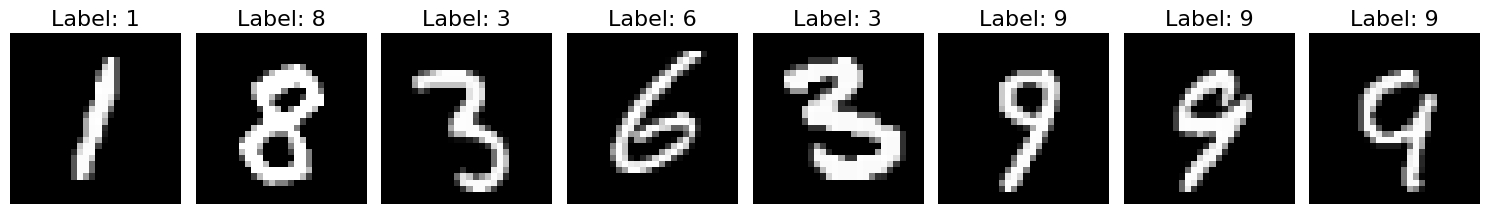

In [19]:
import torch
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 8, figsize=(15, 3))
for ax in axs.ravel():
	img, label = trainset[torch.randint(0, len(trainset), (1,)).squeeze()] # randomly select an image from the training set
	ax.imshow(img.squeeze(), cmap="gray")
	ax.set_title(f"Label: {label}", fontsize=16)
	ax.axis("off")
plt.tight_layout()
plt.show()

We now define the `device` to be used for training the model. We will use the GPU if it's available, otherwise we will use the CPU. The `torch.cuda.is_available()` function returns `True` if the GPU is available, otherwise it returns `False`.

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
print(device)

cuda


## Diffusion process


In this section we will implement the forward and the reverse diffusion processes by defining the `Diffusion` class.

We define the `Diffusion` class with the following methods:
1. `prepare_noise_schedule`: Prepares the noise schedule based on the given `beta_start` and `beta_end` parameters, and the number of steps given by the parameter `noise_steps`.
2. `noise_images`: Implements the forward diffusion process. Given an input image `x`, and the time step `t`, it returns the noisy image `x_t`.
3. `sample_timesteps`: Generates `n` random time steps. This is used during the training process to generate a batch of random time steps for the forward diffusion process.
4. `sample_test_image`: Implements the reverse diffusion process. Generates an image from pure noise.

In [22]:
from tqdm import tqdm

class Diffusion:
	def __init__(
		self,
		noise_steps=1000,
		beta_start=1e-4,
		beta_end=0.02,
		img_size=256,
		device="cuda:0" if torch.cuda.is_available() else "cpu",
	):
		"""
		Parameters
		----------
		noise_steps : int, optional
			Number of steps in the diffusion process, by default 1000
		beta_start : float, optional
			Starting value of the variance schedule $\beta_t$, by default 1e-4
		beta_end : float, optional
			Ending value of the variance schedule $\beta_t$, by default 0.02
		img_size : int, optional
			Size of the image, by default 256
		device : str, optional
			Device to use for the computations, by default "cuda:0" if torch.cuda.is_available() else "cpu"
		"""

		self.noise_steps = noise_steps
		self.beta_start = beta_start
		self.beta_end = beta_end
		self.img_size = img_size
		self.device = device

		self.beta = self.prepare_noise_schedule().to(
			device
		)  # This will create a list of betas from beta_start to beta_end using the prepare_noise_schedule function
		self.alpha = 1.0 - self.beta  # This will create the list of alphas
		self.alpha_bar = torch.cumprod(
			self.alpha, dim=0
		)  # This will create a list of alpha_bars

	def prepare_noise_schedule(self):
		return torch.linspace(self.beta_start, self.beta_end, self.noise_steps) # linear schedule

	def noise_images(self, x, t):
		sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
		sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar[t])[
			:, None, None, None
		]
		noise = torch.randn_like(x)

		return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise, noise

	def sample_timesteps(self, n):
		return torch.randint(low=1, high=self.noise_steps, size=(n,)).to(self.device)

	def sample_test_images(
		self,
		model,
		n, # Number of images to sample
		n_channels, # Number of channels in the image
		position_encoding_dim, # Dimension of the positional encoding
		position_encoding_function, # Positional encoding function
		fixed_noise=None,
		save_time_steps=None,
		save_every=200, # Store the denoised images every "save_every" steps
	):
		"""
        Sample images from the model at different timesteps of the reverse diffusion process.

        Parameters
        ----------
        model : nn.Module
                Model to sample from (prettrained diffusion model)
        n : int
                Number of images to sample
        n_channels : int
                Number of channels in the image
        position_encoding_dim : int
                Dimension of the positional encoding.
        position_encoding_function : function
                Positional encoding function. Function to encode the time step t. For example., sinusoidal position encoding.
        fixed_noise : torch.Tensor, optional
                Fixed noise to use for the sampling, by default None.
        save_time_steps : list, optional
                List of time steps to save the denoised images, by default None.
        save_every : int, optional
                Store the denoised images every "save_every" steps, by default 200
        class_labels : torch.Tensor, optional
                Class labels for the images, by default None
        cfg : bool, optional
                Enable classifier-free guidance. Used for class-conditioned DDPM models. By default False.
        cfg_guidance_strength : int, optional
                Strength of the classifier-free guidance, by default 3
        context : torch.Tensor, optional
                Context for the model, by default None. Used for text-to-image models.
        """
		with torch.no_grad():
			denoised_images = []
			if fixed_noise is not None:
				x = fixed_noise.to(self.device)
			else:
				x = torch.randn((n, n_channels, self.img_size, self.img_size)).to(self.device)
			for i in tqdm(

				reversed(range(1, self.noise_steps)),
				desc="UNet inference",
				total=self.noise_steps,
			):
				t = (torch.ones(n) * i).long()
				t_expdims = position_encoding_function(t.unsqueeze(1), position_encoding_dim).to(self.device)

				predicted_noise = model(x, t_expdims)

				alpha = self.alpha[t][:, None, None, None]
				alpha_bar = self.alpha_bar[t][:, None, None, None]
				beta = self.beta[t][:, None, None, None]
				if i > 1:
					noise = torch.randn_like(x)
				else:
					noise = torch.zeros_like(x)
				x = (
					1
					/ torch.sqrt(alpha)
					* (
						x
						- ((1 - alpha) / (torch.sqrt(1 - alpha_bar))) * predicted_noise
					)
					+ torch.sqrt(beta) * noise
				)

				# Store the denoised images every "save_every" steps
				if save_time_steps is not None:
					if i in save_time_steps:
						denoised_images.append(x)
				else:
					if i % save_every == 1:
						denoised_images.append(x)

			# Convert denoised_images to tensor and swap axes (for plotting)
			denoised_images = torch.stack(denoised_images)
			denoised_images = denoised_images.swapaxes(0, 1)
			return denoised_images

We will now define an instance of the `Diffusion` class to generate the images in the forward diffusion process.

In [23]:
diffusion = Diffusion(
	noise_steps=401,
	beta_start=0.0001,
	beta_end=0.02,
	img_size=28, # MNIST images are 28x28
)

We will sample a random image from the training dataset and generate noise images at different time steps.

In [24]:
clean_image, label = trainset[torch.randint(0, len(trainset), (1,)).squeeze()]

time_steps = [0, 100, 200, 300, 400]

noisy_images = []
for i in range(len(time_steps)):
	noisy_image, noise = diffusion.noise_images(
		x=clean_image[None, ...].to(device), t=torch.tensor([time_steps[i]]).to(device)
	)
	noisy_images.append(noisy_image)

We can now visualize the forward diffusion process for the sampled image.

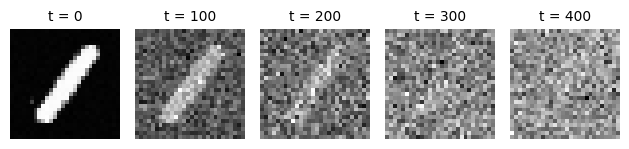

In [25]:
fig, axs = plt.subplots(1, len(time_steps))
for i, ax in enumerate(axs.flatten()):
	ax.imshow(noisy_images[i].cpu().numpy().squeeze(), cmap="gray")
	ax.set_title(f"t = {time_steps[i]}", fontsize=10)
	ax.axis("off")
plt.tight_layout()
plt.show()

## Attention UNet

In this section we will define the Attention UNet that is used in the DDPM model.

We use the class `AttentionUNet` from deeplay to define the Attention UNet architecture. It takes the noisy image and the time step corresponding to the noisy image as input, and returns the noise added to the image as output.

The input channels and output channels are defined the parameters `in_channels` and `out_channels` respectively. The `channels` parameter defines the number of channels in the hidden layers of the UNet, i.e., the number of convolutional filters in the hidden layers.

The `base_channels` parameter defines the number of channels at the base of the UNet, between the encoder and the decoder.

The `channel_attention` parameter can be used to control of attention mechanism that is applied at hidden channels. The boolean values (True or False) defined by the `channel_attention` parameter are used to control the attention mechanism. The first boolean value will be ignored as the time step attention is not included in the first hidden channel. When performing an ablation study, set the attention mechanism to `False` from the end of the list.

The `position_embedding_dim` parameter is used to indicate the dimension of the position encoding of the time step. We will look at it in more detail in the next step.

In [26]:
import deeplay as dl

EMBEDDING_DIM = 256

model = dl.AttentionUNet(
    in_channels=1,
    channels=[32, 64, 128], # Since the image size is 28x28, we cannot use more than three channels
    base_channels=[256,256],
    channel_attention=[True, True, True],
    out_channels=1,
    position_embedding_dim=EMBEDDING_DIM,
)
model.build()
model.to(device)

AttentionUNet(
  (encoder): UNetEncoder(
    (conv_block1): DoubleConvBlock(
      (blocks): LayerList(
        (0): Block(
          (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
          (activation): GELU(approximate='none')
        )
        (1): Block(
          (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
          (activation): Identity()
        )
      )
    )
    (blocks): LayerList(
      (0): FeatureIntegrationModule(
        (conv_block): Sequential(
          (0): DoubleConvBlock(
            (blocks): LayerList(
              (0): Block(
                (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
                (activation): GELU(approximate='none')
              )
          

We will define the position encoding function, `positional_encoding` to convert the time step from a singular value to a position encoding vector. Instead of passing the time step as a singular value, we will pass it as a position encoding vector to the Attention UNet.

In [27]:
def positional_encoding(t, emb_dim):
	inv_freq = 1.0 / (10000 ** (torch.arange(0, emb_dim, 2).float() / emb_dim))
	inv_freq = inv_freq.to(t.device)
	pos_enc_a = torch.sin(t.repeat(1, emb_dim // 2) * inv_freq)
	pos_enc_b = torch.cos(t.repeat(1, emb_dim // 2) * inv_freq)
	pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
	return pos_enc

We now visualize the position encodings generated for different time steps. As we can see, the position encodings are different for different time steps. Each row in the plot corresponds to the position encoding for a time step.

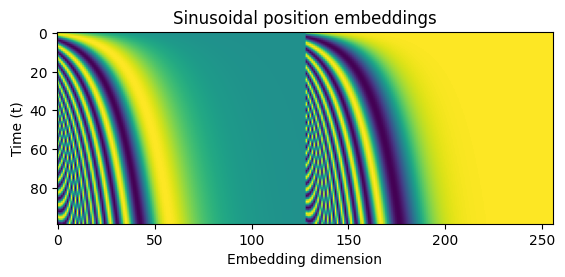

In [28]:
pos_encs = []

for i in range(1, 100):
	t = torch.tensor([i])
	pos_enc = positional_encoding(t, EMBEDDING_DIM)
	pos_encs.append(pos_enc.squeeze())

pos_encs = torch.stack(pos_encs)

fig = plt.figure()
plt.imshow(pos_encs.cpu().numpy())
plt.xlabel("Embedding dimension")
plt.ylabel("Time (t)")
plt.title("Sinusoidal position embeddings")
plt.show()

### Optimizers

We will define the optimizer and learning rate for the model. We will use the Adam optimizer with a learning rate of 1e-4.

In [29]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

### Loss function

We will use a mean squared error loss function to train the model.

In [30]:
criterion = torch.nn.MSELoss()

### Data loaders

We now define the data loaders for the training and test datasets. We will use a batch size of `128` as defined by the `batch_size` parameter. We will also set the `shuffle` parameter to `True` for the training data loader to shuffle the training dataset.

In [31]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128

train_loader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=valset, batch_size=BATCH_SIZE, shuffle=True)

## Training procedure

We now define an instance of the `Diffusion` class with 1000 noise steps for training the model.

In [32]:
IMAGE_SIZE = 28
NOISE_STEPS = 1000

diffusion = Diffusion(img_size=IMAGE_SIZE, noise_steps=NOISE_STEPS, device=device)

We now define a helper function `prepare_data` to prepare the data for training the model. The function takes a clean image from the dataset, and returns the noisy image, time step, and the noise added to the image. The former two are used as input to the model, and the latter is used as the target output.

In [33]:
def prepare_data(image, device=device):
    
    # Generate noise and timesteps and apply diffusion
    batch_size = image.shape[0]
    t = diffusion.sample_timesteps(batch_size)
    image = image.to(device)
    x_t, noise = diffusion.noise_images(image, t)
    t = positional_encoding(t.unsqueeze(1), EMBEDDING_DIM) 

    # Move to device
    x_t = x_t.to(device)
    t = t.to(device)
    noise = noise.to(device)

    return x_t, t, noise

We now define the training loop for the DDPM model for generating MNIST digits from a noise image. We will train the model for 20 epochs defined by the `EPOCHS` parameter.

Once every epoch, we will print the losses, time taken for the epoch, and also visualize the generated images.



Epoch 1 / 20
__________


Batch 1 / 469: Train loss: 1.1885
Batch 101 / 469: Train loss: 0.1275
Batch 201 / 469: Train loss: 0.0856
Batch 301 / 469: Train loss: 0.0670
Batch 401 / 469: Train loss: 0.0656
----------
Epoch 1/20 : Train loss: 0.1092, Val loss: 0.0546
Time taken: 0:00:45.039871


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:15<00:00, 63.71it/s]


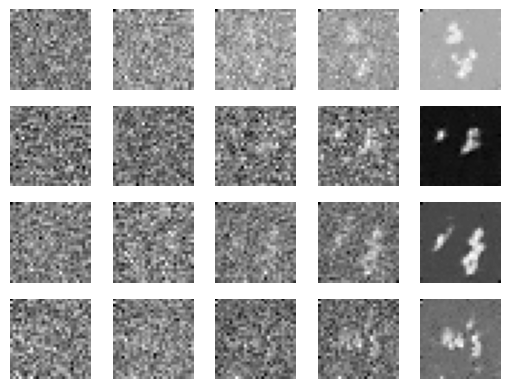



Epoch 2 / 20
__________
Batch 1 / 469: Train loss: 0.0478
Batch 101 / 469: Train loss: 0.0389
Batch 201 / 469: Train loss: 0.0492
Batch 301 / 469: Train loss: 0.0429
Batch 401 / 469: Train loss: 0.0459
----------
Epoch 2/20 : Train loss: 0.0459, Val loss: 0.0446
Time taken: 0:00:48.984021


UNet inference: 100%|██████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:07<00:00, 129.71it/s]


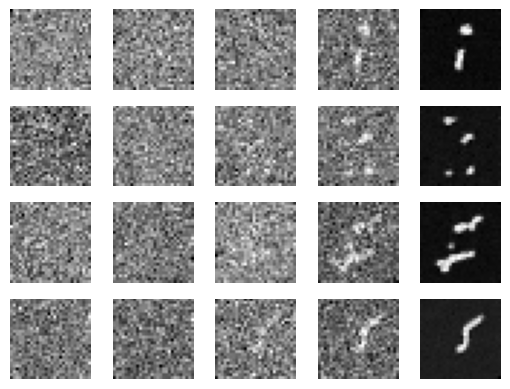



Epoch 3 / 20
__________
Batch 1 / 469: Train loss: 0.0368
Batch 101 / 469: Train loss: 0.0451
Batch 201 / 469: Train loss: 0.0369
Batch 301 / 469: Train loss: 0.0517
Batch 401 / 469: Train loss: 0.0361
----------
Epoch 3/20 : Train loss: 0.0384, Val loss: 0.0352
Time taken: 0:00:54.313657


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:15<00:00, 63.79it/s]


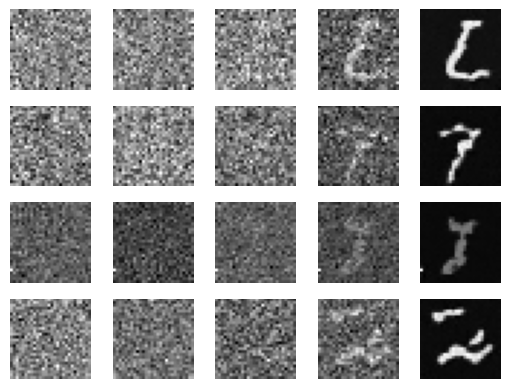



Epoch 4 / 20
__________
Batch 1 / 469: Train loss: 0.0367
Batch 101 / 469: Train loss: 0.0357
Batch 201 / 469: Train loss: 0.0303
Batch 301 / 469: Train loss: 0.0350
Batch 401 / 469: Train loss: 0.0366
----------
Epoch 4/20 : Train loss: 0.0339, Val loss: 0.0318
Time taken: 0:00:42.604861


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:15<00:00, 64.16it/s]


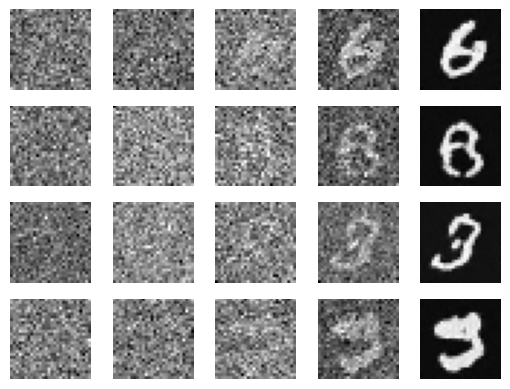



Epoch 5 / 20
__________
Batch 1 / 469: Train loss: 0.0264
Batch 101 / 469: Train loss: 0.0405
Batch 201 / 469: Train loss: 0.0311
Batch 301 / 469: Train loss: 0.0308
Batch 401 / 469: Train loss: 0.0275
----------
Epoch 5/20 : Train loss: 0.0322, Val loss: 0.0317
Time taken: 0:00:54.598550


UNet inference: 100%|██████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:07<00:00, 139.12it/s]


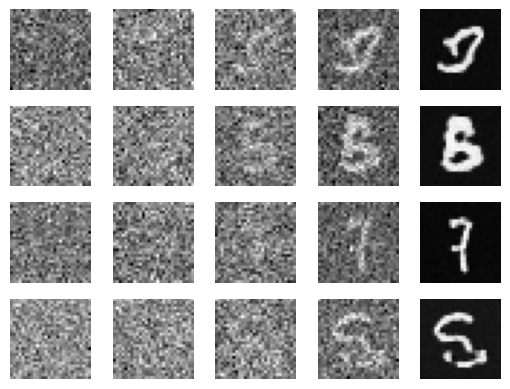



Epoch 6 / 20
__________
Batch 1 / 469: Train loss: 0.0284
Batch 101 / 469: Train loss: 0.0277
Batch 201 / 469: Train loss: 0.0287
Batch 301 / 469: Train loss: 0.0332
Batch 401 / 469: Train loss: 0.0273
----------
Epoch 6/20 : Train loss: 0.0306, Val loss: 0.0297
Time taken: 0:00:48.465470


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:15<00:00, 63.18it/s]


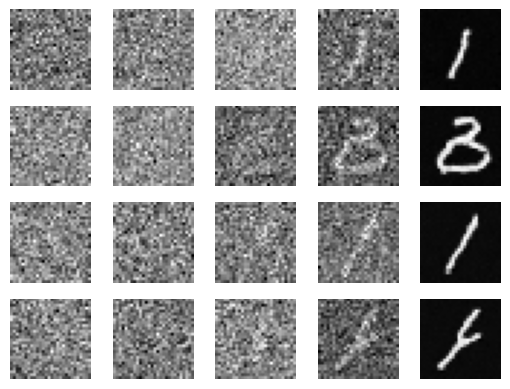



Epoch 7 / 20
__________
Batch 1 / 469: Train loss: 0.0310
Batch 101 / 469: Train loss: 0.0284
Batch 201 / 469: Train loss: 0.0272
Batch 301 / 469: Train loss: 0.0320
Batch 401 / 469: Train loss: 0.0361
----------
Epoch 7/20 : Train loss: 0.0294, Val loss: 0.0287
Time taken: 0:00:43.798465


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:11<00:00, 83.29it/s]


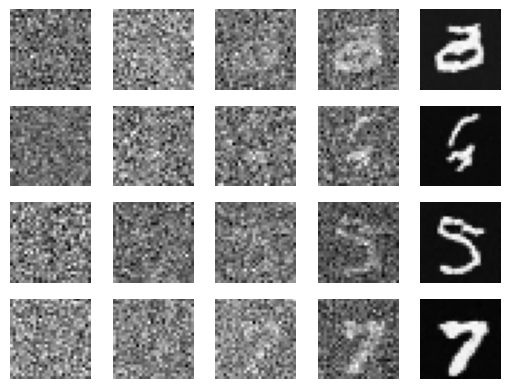



Epoch 8 / 20
__________
Batch 1 / 469: Train loss: 0.0356
Batch 101 / 469: Train loss: 0.0214
Batch 201 / 469: Train loss: 0.0305
Batch 301 / 469: Train loss: 0.0315
Batch 401 / 469: Train loss: 0.0276
----------
Epoch 8/20 : Train loss: 0.0286, Val loss: 0.0277
Time taken: 0:00:55.293052


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:15<00:00, 64.04it/s]


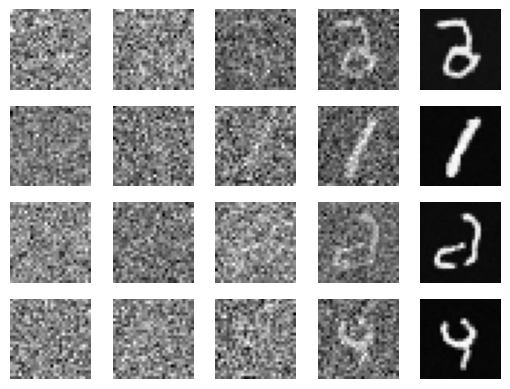



Epoch 9 / 20
__________
Batch 1 / 469: Train loss: 0.0293
Batch 101 / 469: Train loss: 0.0307
Batch 201 / 469: Train loss: 0.0304
Batch 301 / 469: Train loss: 0.0212
Batch 401 / 469: Train loss: 0.0283
----------
Epoch 9/20 : Train loss: 0.0278, Val loss: 0.0270
Time taken: 0:00:39.755911


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:15<00:00, 64.34it/s]


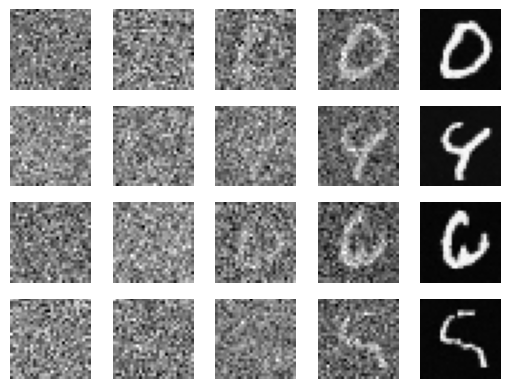



Epoch 10 / 20
__________
Batch 1 / 469: Train loss: 0.0301
Batch 101 / 469: Train loss: 0.0234
Batch 201 / 469: Train loss: 0.0325
Batch 301 / 469: Train loss: 0.0265
Batch 401 / 469: Train loss: 0.0337
----------
Epoch 10/20 : Train loss: 0.0273, Val loss: 0.0266
Time taken: 0:00:51.246532


UNet inference: 100%|██████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:08<00:00, 117.58it/s]


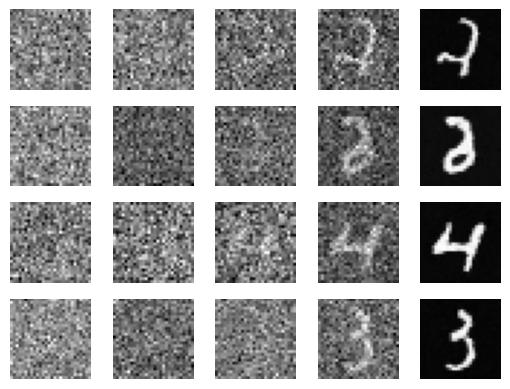



Epoch 11 / 20
__________
Batch 1 / 469: Train loss: 0.0283
Batch 101 / 469: Train loss: 0.0261
Batch 201 / 469: Train loss: 0.0208
Batch 301 / 469: Train loss: 0.0253
Batch 401 / 469: Train loss: 0.0318
----------
Epoch 11/20 : Train loss: 0.0268, Val loss: 0.0262
Time taken: 0:00:52.010289


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:15<00:00, 64.53it/s]


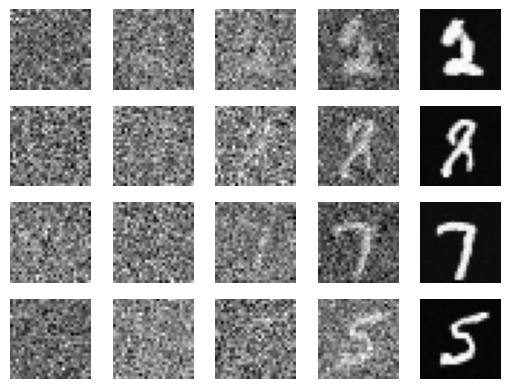



Epoch 12 / 20
__________
Batch 1 / 469: Train loss: 0.0240
Batch 101 / 469: Train loss: 0.0232
Batch 201 / 469: Train loss: 0.0340
Batch 301 / 469: Train loss: 0.0194
Batch 401 / 469: Train loss: 0.0252
----------
Epoch 12/20 : Train loss: 0.0263, Val loss: 0.0255
Time taken: 0:00:41.231951


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:15<00:00, 64.12it/s]


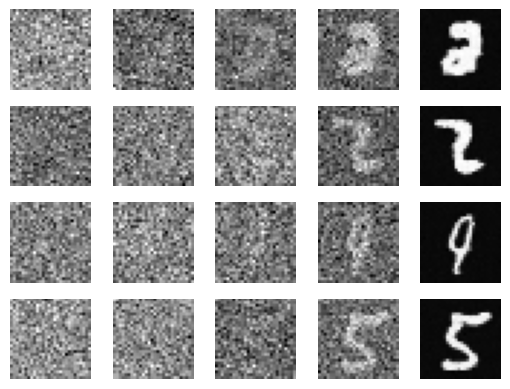



Epoch 13 / 20
__________
Batch 1 / 469: Train loss: 0.0319
Batch 101 / 469: Train loss: 0.0267
Batch 201 / 469: Train loss: 0.0235
Batch 301 / 469: Train loss: 0.0228
Batch 401 / 469: Train loss: 0.0292
----------
Epoch 13/20 : Train loss: 0.0260, Val loss: 0.0250
Time taken: 0:00:55.364346


UNet inference: 100%|██████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:09<00:00, 108.80it/s]


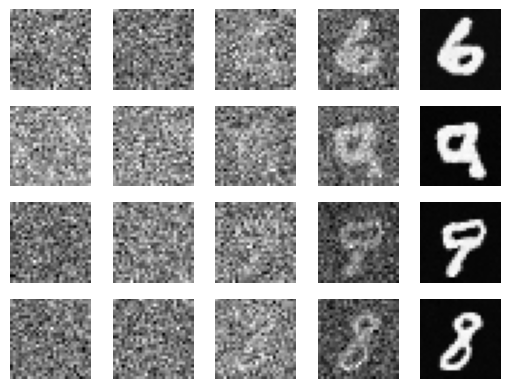



Epoch 14 / 20
__________
Batch 1 / 469: Train loss: 0.0301
Batch 101 / 469: Train loss: 0.0206
Batch 201 / 469: Train loss: 0.0217
Batch 301 / 469: Train loss: 0.0257
Batch 401 / 469: Train loss: 0.0249
----------
Epoch 14/20 : Train loss: 0.0258, Val loss: 0.0253
Time taken: 0:00:45.634621


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:15<00:00, 64.31it/s]


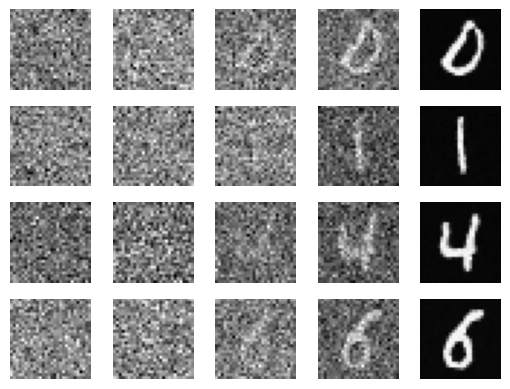



Epoch 15 / 20
__________
Batch 1 / 469: Train loss: 0.0236
Batch 101 / 469: Train loss: 0.0219
Batch 201 / 469: Train loss: 0.0253
Batch 301 / 469: Train loss: 0.0238
Batch 401 / 469: Train loss: 0.0253
----------
Epoch 15/20 : Train loss: 0.0256, Val loss: 0.0244
Time taken: 0:00:47.126745


UNet inference: 100%|██████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:07<00:00, 134.60it/s]


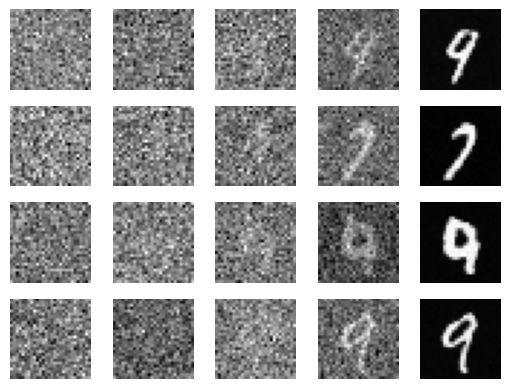



Epoch 16 / 20
__________
Batch 1 / 469: Train loss: 0.0263
Batch 101 / 469: Train loss: 0.0223
Batch 201 / 469: Train loss: 0.0236
Batch 301 / 469: Train loss: 0.0214
Batch 401 / 469: Train loss: 0.0231
----------
Epoch 16/20 : Train loss: 0.0251, Val loss: 0.0245
Time taken: 0:00:55.208874


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:15<00:00, 64.13it/s]


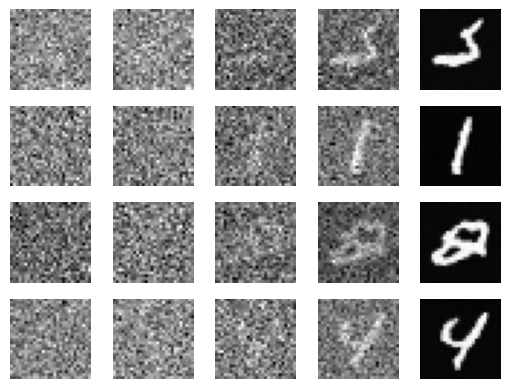



Epoch 17 / 20
__________
Batch 1 / 469: Train loss: 0.0320
Batch 101 / 469: Train loss: 0.0290
Batch 201 / 469: Train loss: 0.0268
Batch 301 / 469: Train loss: 0.0241
Batch 401 / 469: Train loss: 0.0302
----------
Epoch 17/20 : Train loss: 0.0248, Val loss: 0.0249
Time taken: 0:00:41.105720


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:15<00:00, 64.77it/s]


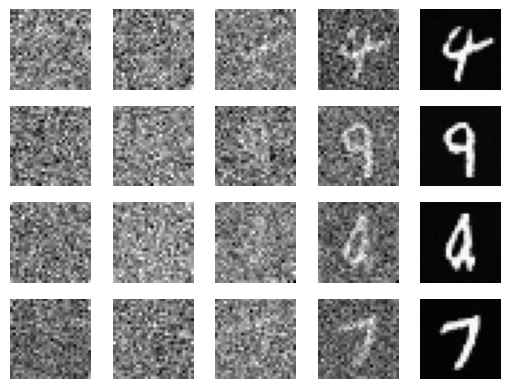



Epoch 18 / 20
__________
Batch 1 / 469: Train loss: 0.0261
Batch 101 / 469: Train loss: 0.0317
Batch 201 / 469: Train loss: 0.0251
Batch 301 / 469: Train loss: 0.0261
Batch 401 / 469: Train loss: 0.0213
----------
Epoch 18/20 : Train loss: 0.0248, Val loss: 0.0249
Time taken: 0:00:54.179011


UNet inference: 100%|██████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:08<00:00, 121.45it/s]


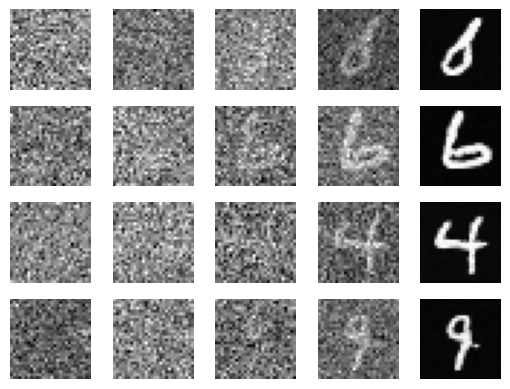



Epoch 19 / 20
__________
Batch 1 / 469: Train loss: 0.0285
Batch 101 / 469: Train loss: 0.0217
Batch 201 / 469: Train loss: 0.0255
Batch 301 / 469: Train loss: 0.0202
Batch 401 / 469: Train loss: 0.0206
----------
Epoch 19/20 : Train loss: 0.0246, Val loss: 0.0259
Time taken: 0:00:48.635578


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:15<00:00, 64.51it/s]


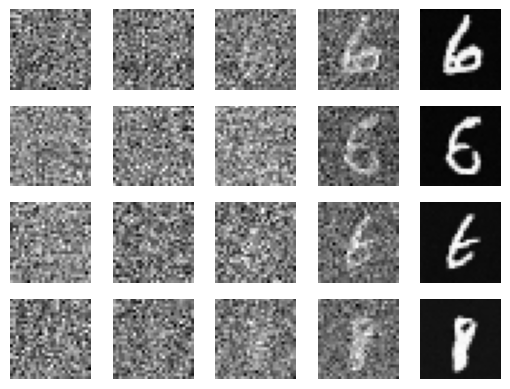



Epoch 20 / 20
__________
Batch 1 / 469: Train loss: 0.0235
Batch 101 / 469: Train loss: 0.0237
Batch 201 / 469: Train loss: 0.0248
Batch 301 / 469: Train loss: 0.0265
Batch 401 / 469: Train loss: 0.0306
----------
Epoch 20/20 : Train loss: 0.0244, Val loss: 0.0240
Time taken: 0:00:42.268143


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:14<00:00, 69.55it/s]


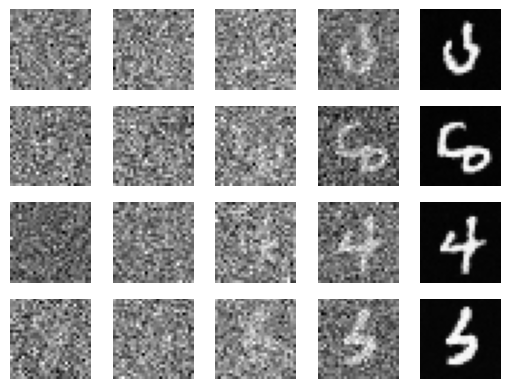

In [34]:
EPOCHS = 20

# Import the packages required for checking the time taken for each epoch
import time
from datetime import timedelta

# Create empty lists to store the train and validation loss
train_loss = []
val_loss = []

# Training loop
for epoch in range(EPOCHS):

    # Record the start time of the epoch
    start_time = time.time()

    num_batches = len(train_loader)

    print("\n")
    print(f"Epoch {epoch+1} / {EPOCHS}")
    print("_" * 10)

    model.train(True)

    running_loss = 0.0
    for batch_idx, (image, class_labels) in enumerate(train_loader, start=0):

        # Prepare data
        x_t, t, noise = prepare_data(image)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + Reverse + Gradients
        outputs = model(x_t, t)
        loss = criterion(outputs, noise)
        loss.backward()
        optimizer.step()

        # Print loss after certian number of batches
        if batch_idx % 100 == 0:
            print(
                f"Batch {batch_idx+1} / {num_batches}: Train loss: {loss.item():.4f}"
            )

        # Update the running loss
        running_loss += loss.item()

    # Store the training loss for this epoch
    train_loss.append(running_loss / len(train_loader))

    # Validation
    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        running_loss = 0.0
        for batch_idx, (image, class_labels) in enumerate(val_loader):
            # Prepare data
            x_t, t, noise = prepare_data(image)

            # Forward pass
            outputs = model(x_t, t)
            loss = criterion(outputs, noise)

            # Update the running loss
            running_loss += loss.item()

        # Store the validation loss for this epoch
        val_loss.append(running_loss / len(val_loader))

    # Record the end time of the epoch
    end_time = time.time()

    # print the loss for this epoch
    print("-" * 10)
    print(
        f"Epoch {epoch+1}/{EPOCHS} : Train loss: {train_loss[-1]:.4f}, Val loss: {val_loss[-1]:.4f}"
    )
    print(f"Time taken: {timedelta(seconds=end_time - start_time)}")

    # Generate some images every epoch
    num_images = 4

    generated_images = diffusion.sample_test_images(
        model,
        n=num_images,
        n_channels=1,
        position_encoding_dim=EMBEDDING_DIM,
        position_encoding_function=positional_encoding,
        n_channels=1,
        save_every=200,
    )

    # plot generated images
    fig = plt.figure()
    for inx in range(num_images):
        image_reverse_diff_traj = generated_images[inx]

        for i in range(len(image_reverse_diff_traj)):
            plt.subplot(num_images, len(image_reverse_diff_traj), inx * len(image_reverse_diff_traj) + i + 1)
            plt.imshow(image_reverse_diff_traj[i].permute(1, 2, 0).cpu().numpy(), cmap="gray")
            plt.axis("off")
    plt.show()


### Sample images

Using the trained model, we will generate some images from pure noise using the reverse diffusion process.

UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:15<00:00, 64.47it/s]


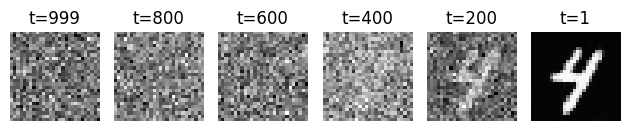

In [35]:
# Set the model to evaluation mode
model.eval()

# Denormalize the image
def denormalize_noise(image):
    image = image.permute(1, 2, 0).cpu().numpy()
    image = image * 0.5 + 0.5
    return image

# Fixed noise for sampling
fixed_noise = torch.randn((1, 1, IMAGE_SIZE, IMAGE_SIZE))
save_time_steps = [999, 800, 600, 400, 200, 1] # Sample images at these time steps

# Generate images
processed_images = diffusion.sample_test_images(
    model,
    n=1,
    n_channels=1,
    fixed_noise=fixed_noise,
    position_encoding_dim=EMBEDDING_DIM,
    position_encoding_function=positional_encoding,
    save_every=200,
    save_time_steps=save_time_steps,
)  # Outputs a tensor of shape (1, t_noise, n_channels, 28, 28) where t_noise is the number of noise steps for plotting

# Plot the reverse diffusion process
fig, axs = plt.subplots(1, len(save_time_steps))
for j in range(len(save_time_steps)):
    axs[j].imshow(denormalize_noise(processed_images[0, j]), cmap="gray")
    axs[j].set_title(f"t={save_time_steps[j]}")
    axs[j].axis("off")
plt.tight_layout()
plt.show()

### Plot losses

We now plot the losses for the training and test datasets.

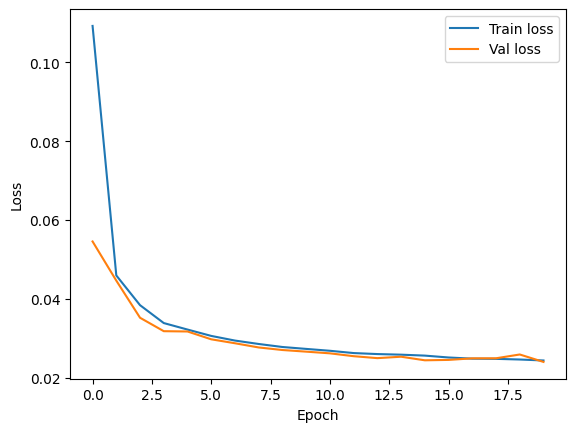

In [36]:
plt.plot(train_loss, label="Train loss")
plt.plot(val_loss, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Similarity test

We now implement a similarity test to compare generated images with training images.

We first define a scoring function `compute_l1_score` to compute the L1 score between the generated images and the training images. We will normalise the images using the `normalize_min_max`function before computing the L1 score. This ensures that the pixel values of the images are between 0 and 1.

In [37]:
def normalize_minmax(tensor):
    min_val = tensor.min(dim=-1, keepdim=True)[0]
    max_val = tensor.max(dim=-1, keepdim=True)[0]
    tensor = (tensor - min_val) / (max_val - min_val)
    return tensor

def compute_l1_score(x, y):
    x = normalize_minmax(x)
    y = normalize_minmax(y)
    differences = torch.abs(x - y)
    loss = differences.sum(dim=-1)
    return loss

We now generate 256 images from the trained model, and compare them with the 60000 training images to compute the L1 score. Instead of generating the 256 images in a single batch, we will generate them in two batches of 128 images each. We will then compute the L1 score for each batch of generated images.

In [83]:
# Create trainloader with shuffle=False
train_loader = DataLoader(dataset=trainset, batch_size=128, shuffle=False)

# Create an empty list to store the L1 similarities
L1_similarities = []

# Create an empty list to store the generated images
generated_images_stack = []

for repeat in range(2):  # Repeat 10 times to get 1280 images
    generated_images = diffusion.sample_test_images(
        model, # Trained model
        n=128, # Number of images to sample
        n_channels=1,
        position_encoding_dim=EMBEDDING_DIM,
        position_encoding_function=positional_encoding,
        save_time_steps=[1],  # Stores the final denoised image
    ).squeeze()

    generated_images_stack.append(generated_images)

    # Initialize an empty tensor to store the L1 distances for this set of generated images
    distances_for_this_repeat = torch.empty((128, 0)).to(device)

    # Loop the generate images through the training set
    for batch_idx, (image, class_labels) in enumerate(train_loader, start=0):

        # Break if batch size is not 128
        if image.shape[0] != 128:
            break

        # Reshaping and broadcasting the training images
        training_images = image.squeeze().view(-1, 28 * 28)  # shape: (128, 784)
        training_images = training_images[None, :, :]  # shape: (1, 128, 784)
        training_images = training_images.to(device)

        # Reshaping and broadcasting the generated images
        generated_images_reshaped = generated_images.view(-1, 28 * 28)  # shape: (128, 784)
        generated_images_reshaped = generated_images_reshaped[:, None, :]  # shape: (128, 1, 784)

        # Compute the L1 score
        l1_score = compute_l1_score(
            training_images, generated_images_reshaped)  # shape: (128, 128)

        # Concatenate the current l1_score tensor to distances_for_this_repeat
        distances_for_this_repeat = torch.cat(
            [distances_for_this_repeat, l1_score], dim=1 
        ) # shape: (128, 60000) after the all the batches have been processed

    # Append the distances tensor for this set of generated images to L1_similarities list
    L1_similarities.append(distances_for_this_repeat)

# Now, concatenate all tensors in the L1_similarities list to get a single tensor
final_L1_similarities = torch.cat(L1_similarities, dim=0)  # shape: (256, 60000)

generated_images_stack = torch.cat(generated_images_stack, dim=0)
print("Generated images shape: ", generated_images_stack.shape)

# The shape of final_L1_similarities should be (128*number_of_repeats, 60000)
print("L1 similarities shape: ", final_L1_similarities.shape)

UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:35<00:00, 28.31it/s]


Generated images shape:  torch.Size([256, 28, 28])
L1 similarities shape:  torch.Size([256, 59904])


We now visualize the histogram of the L1 scores for the generated images. We will flatten the `[256, 60000]` array of L1 scores to a single array of length `256 * 60000` before plotting the histogram.

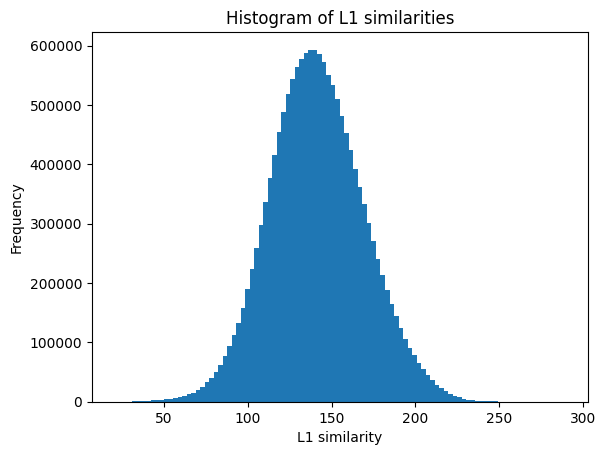

In [84]:
plt.figure()
plt.hist(final_L1_similarities.cpu().numpy().flatten(), bins=100)
plt.title("Histogram of L1 similarities")
plt.xlabel("L1 similarity")
plt.ylabel("Frequency")
plt.show()

As we can see, the distribution of L1 score is bell shaped indicating that the model is not overfitting to the training data. If the model is overfitting, the distribution of L1 score will be skewed to the left. Now let us visualize some of the low scoring generated and training images and observe how close they look.

We will define the threshold for the L1 score with the `THRESHOLD` parameter.


In [87]:
THRESHOLD = 50

# Create empty Lists to store the images corresponding to low L1 scores
low_score_generated_images = []
low_score_training_images = []

# Get the indices of the training images with the lowest L1 score for each generated image
min_l1_indices = torch.argmin(final_L1_similarities, dim=1)

# Itertate over each generated image and its corresponding lowest L1 training image index
for gen_img_idx, train_img_idx in enumerate(min_l1_indices):
    low_l1_score = final_L1_similarities[gen_img_idx, train_img_idx]

    # Check if the L1 score is below a certain threshold to consider it 'low'
    if low_l1_score < THRESHOLD:

        low_score_generated_images.append(generated_images_stack[gen_img_idx])
        low_score_training_images.append(trainset[train_img_idx][0])

We will now visualize the low scoring generated images and the corresponding training images. We will sample random images using the `image_index` parameter.

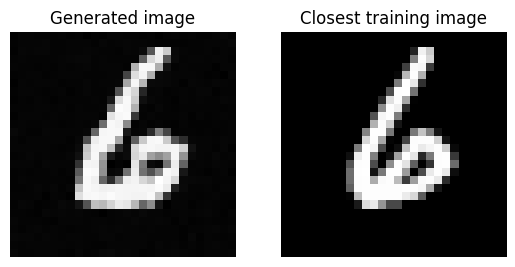

In [129]:
image_index = torch.randint(0, len(low_score_generated_images), (1,)).item()

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(low_score_generated_images[image_index].cpu().numpy().squeeze(), cmap="gray")
plt.title("Generated image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(low_score_training_images[image_index].squeeze(), cmap="gray")
plt.title("Closest training image")
plt.axis("off")
plt.show()